<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Analyzing_data_in_the_JARVIS_Leaderboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analyzing data in JARVIS-Leaderbaord

In [1]:
import os
if not os.path.exists('jarvis_leaderboard'):
  !git clone https://github.com/usnistgov/jarvis_leaderboard.git

Cloning into 'jarvis_leaderboard'...
remote: Enumerating objects: 19312, done.
remote: Counting objects: 100% (6537/6537), done.
remote: Compressing objects: 100% (1938/1938), done.
remote: Total 19312 (delta 2954), reused 6278 (delta 2767), pack-reused 12775
Receiving objects: 100% (19312/19312), 124.91 MiB | 16.52 MiB/s, done.
Resolving deltas: 100% (9804/9804), done.


In [2]:
os.chdir('jarvis_leaderboard/jarvis_leaderboard/notebooks')

In [3]:
pip install jarvis_leaderboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.8/973.8 kB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: markdown
    Found existing installation: Markdown 3.4.3
    Uninstalling Markdown-3.4.3:
      Successfully uninstalled Markdown-3.4.3


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import zipfile
import numpy as np
import json,os
from jarvis.db.jsonutils import loadjson
from collections import defaultdict
import pandas as pd
from sklearn.metrics import mean_absolute_error, accuracy_score
def get_metric_value(
    submod="",
    csv_path="",
    dataset="",
    prop="",
    data_split="",
    method="",
    metric="",
    bench_name="",
):
    results = {}
    results["method"] = method
    results["submod"] = submod
    results["dataset"] = dataset
    results["prop"] = prop
    results["data_split"] = data_split
    results["csv_path"] = csv_path
    results["metric"] = metric
    csv_data = pd.read_csv(csv_path, sep=",")
    meta_path = csv_path.split("/")
    meta_path[-1] = "metadata.json"
    meta_path = "/".join(meta_path)
    meta_data = loadjson(meta_path)
    results["model_name"] = meta_data["model_name"]
    results["team_name"] = meta_data["team_name"]
    results["date_submitted"] = meta_data["date_submitted"]
    results["project_url"] = meta_data["project_url"]
    results["num_entries"] = len(csv_data)
    results["github_url"] = (
        "https://github.com/usnistgov/jarvis_leaderboard/tree/main/jarvis_leaderboard/contributions/"
        + bench_name
    )  # meta_path.split('metadata.json')[0]

    # print("meta_path", meta_data)
    # meta_data=loadjson()
    # print("csv_data", csv_path)
    # dataset with actual values
    temp = dataset + "_" + prop + ".json"
    # print ('json temp',temp)
    temp2 = temp + ".zip"
    fname = os.path.join("benchmarks", method, submod, temp2)
    fname2 = os.path.join(root_dir, fname)

    z = zipfile.ZipFile(fname2)
    json_data = json.loads(z.read(temp))

    # json_data = loadjson(os.path.join(root_dir, fname))
    actual_data_json = json_data[data_split]
    if "val" in json_data:  # sometimes just train-test
        data_size = (
            len(json_data["train"])
            + len(json_data["val"])
            + len(json_data["test"])
        )
    else:
        data_size = len(json_data["train"]) + len(json_data["test"])
    # print ('actual_data_json',actual_data_json)
    results["dataset_size"] = data_size
    ids = []
    targets = []
    for i, j in actual_data_json.items():
        ids.append(i)
        targets.append(j)
    mem = {"id": ids, "actual": targets}
    actual_df = pd.DataFrame(mem)
    # print ('actual_df',actual_df)
    # print('csv_data',csv_data)
    # actual_df.to_csv('actual_df.csv')
    # csv_data.to_csv('csv_data.csv')
    csv_data["id"] = csv_data["id"].astype(str)
    actual_df["id"] = actual_df["id"].astype(str)
    if len(csv_data) != len(actual_df):
        print("Error", csv_path, len(csv_data), len(actual_df))
        errors.append(csv_path)

    df = pd.merge(csv_data, actual_df, on="id")
    # print('csv',csv_path)
    # print ('df',df)
    # print('csv_data',csv_data)
    # print('actual_df',actual_df)
    results["res"] = "na"
    results["df"] = df
    if metric == "mae":
        res = round(mean_absolute_error(df["actual"], df["prediction"]), 3)
        results["res"] = res
        if "qm9_std_jctc" in csv_path:
            # print('scaling[dataset][prop],',scaling[dataset][prop])
            res = round(
                scaling[dataset][prop]
                * mean_absolute_error(df["actual"], df["prediction"]),
                3,
            )
            results["res"] = res
            # print(csv_path)
            # print('mae1',mean_absolute_error(csv_data['target'],csv_data['prediction']))
            # print('res',res)
            # print(csv_data)
            # print(actual_df)
            # print()
    if metric == "acc":
        # print("ACC",csv_path)
        # print(df, len(df))
        res = round(accuracy_score(df["actual"], df["prediction"]), 3)
        # print("res", res)
        results["res"] = res
    if metric == "multimae":
        # print("csv multimae", csv_path)
        # print ('df',df)
        maes = []
        for k, v in df.iterrows():
            real = np.array(v["actual"].split(";"), dtype="float")
            # real = np.array(v["target"].split(";"), dtype="float")
            pred = np.array(v["prediction"].split(";"), dtype="float")
            m = mean_absolute_error(real, pred)
            maes.append(m)
            # print('mm',m)
        results["res"] = round(np.array(maes).sum(), 3)
        # print ('df',df)
        # print('csv_data',csv_data)
        # print('actual_df',actual_df)
        # print('res',results['res'])

    return results

def mean_absolute_deviation(data, axis=None):
    """Get Mean absolute deviation."""
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)

In [7]:
info = defaultdict()
id_info = defaultdict()
root_dir='..'
metric_names=[]
#qm9 used mean/std scaling
scaling = {
    "qm9_std_jctc": {
        "alpha": 8.172947,
        "mu": 1.503449,
        "HOMO": 0.597728,
        "LUMO": 1.274800,
        "gap": 1.284114,
        "R2": 280.472586,
        "ZPVE": 0.901645,
        "U0": 10.322918,
        "U": 10.414332,
        "H": 10.488418,
        "G": 9.497589,
        "Cv": 4.067492,
    }
}
mad_vals=[]
mae_vals=[]
mae_over_mad_vals=[]
mae_model_names=[]
nm_count=0
nm_index=[]

#example benchmarks for plotting
ai_form_en={}
es_kv={}
qc_eig={}
exp_co2={}


#all the benchmark csv.zip files
for i in glob.glob("../contributions/*/*.csv.zip"):

    fname = i.split("/")[-1].split(".csv.zip")[0]
    temp = fname.split("-")
    dataset = temp[3]
    bench_name = i.split("/")[-2]
    prop = temp[2]
    submod = temp[1]
    method = temp[0]
    metric = temp[-1]
    metric_names.append(metric)
    data_split='test'
    json_name = dataset + "_" + prop + ".json"
    json_path = '../benchmarks/'+method+'/'+submod+'/'+json_name+'.zip'
    z = zipfile.ZipFile(json_path)
    json_data = json.loads(z.read(json_name))
    if dataset not in id_info:
        id_info[dataset]=[]
    if "val" in json_data:  # sometimes just train-test
        data_size = (
            len(json_data["train"])
            + len(json_data["val"])
            + len(json_data["test"])
        )
        for m in list(json_data["train"].keys()):
          
                id_info[dataset].append(m)
        for m in list(json_data["val"].keys()):
           
                id_info[dataset].append(m)
        for m in list(json_data["test"].keys()):
            
                id_info[dataset].append(m)
    else:
        data_size = len(json_data["train"]) + len(json_data["test"])
        for m in list(json_data["train"].keys()):
            
                id_info[dataset].append(m)

        for m in list(json_data["test"].keys()):
           
                id_info[dataset].append(m)
    res = get_metric_value(
        submod=submod,
        csv_path=i,
        dataset=dataset,
        prop=prop,
        data_split=data_split,
        method=method,
        metric=metric,
        bench_name=bench_name,
    )
    if i.split('/')[-1]=='AI-SinglePropertyPrediction-formation_energy_peratom-dft_3d-test-mae.csv.zip':
        ai_form_en[bench_name]=res['df']
  
    if i.split('/')[-1]=='ES-SinglePropertyPrediction-bulk_modulus-dft_3d-test-mae.csv.zip':
        es_kv[bench_name]=res['df']
    if i.split('/')[-1]=='QC-EigenSolver-electron_bands_JVASP_816_Al_WTBH-dft_3d-test-multimae.csv.zip':
        qc_eig[bench_name]=res['df']
    if i.split('/')[-1]=='EXP-Spectra-co2_RM_8852-nist_isodb-test-multimae.csv.zip':
        exp_co2[bench_name]=res['df']
        
    if  metric=='mae' and 'JVASP_' not in i:
        if len(json_data["train"])==0:
            tdata=[]
            for m in list(json_data["test"].values()):
                tdata.append(m)    
        else:
            tdata=[]
            for m in list(json_data["train"].values()):
                tdata.append(m)
        tdata=np.array(tdata,dtype='float')
        mad=mean_absolute_deviation(tdata)
        mad_vals.append(mad)
        mae=res['res']
        mae_vals.append(mae)
        
        if mad/mae<100:
            nm_count+=1
            mae_over_mad_vals.append(mad/mae)
            nm=i.split('/')[-1].split('-test-mae.csv.zip')[0].split('-')[2].split('_m2cm3')[0].replace('optb88vdw','OPT')
            
            #if mad>100 and 'm2g' not in i:
            if len(mae_vals)%15==0 or 'surface_area_m2cm3' in i or 'n_powerfact' in i:
#                 if 'n_powerfact' in i:
#                     nm_index.append(nm_count-1)
#                 else:
#                 #mae_model_names.append(nm)
                nm_index.append(nm_count)
                mae_model_names.append(nm)
        
                print ('mad',mad,mad/mae,i)
        #break
#     if dataset not in info:
#         info[dataset]=data_size #[data_size]
#     else:
#         info[dataset]=info[dataset]+data_size #.append(data_size)

    #print (dataset,prop,submod,method,json_name)
    #break

mad 608.1598193707139 5.6411381286241635 ../contributions/alignn_model/AI-SinglePropertyPrediction-surface_area_m2cm3-hmof-test-mae.csv.zip
mad 61.21596670622402 2.5795780500705416 ../contributions/alignn_model/AI-SinglePropertyPrediction-mepsz-dft_3d-test-mae.csv.zip
mad 42.09502346603152 4.382159428069073 ../contributions/alignn_model/AI-SinglePropertyPrediction-ph_heat_capacity-dft_3d-test-mae.csv.zip
mad 0.18197245240630505 10.704261906253237 ../contributions/alignn_model/AI-SinglePropertyPrediction-void_fraction-hmof-test-mae.csv.zip
mad 691.5759916864997 1.5635938396571092 ../contributions/alignn_model/AI-SinglePropertyPrediction-n_powerfact-dft_3d-test-mae.csv.zip
mad 22.534358906793635 0.11158219440559751 ../contributions/alignnff_wt10/AI-MLFF-energy-mlearn_Ge-test-mae.csv.zip
mad 260.05808207313635 1.8103086727354363 ../contributions/kgcnn_schnet/AI-SinglePropertyPrediction-encut-dft_3d-test-mae.csv.zip
mad 65.6154300591716 1.2701153686373008 ../contributions/matformer/AI-Sing

Benchmark datasets

alignn_ff_db 2149777 307111
dft_3d 3704565 55713
arXiv 908946 87148
pubchem 400500 44500
qm9_std_jctc 1569948 130829
hmof 963557 137651
qe_tb 2488722 829574
snumat 10386 10386
edos_pdos 14243 14243
qmof 20424 20424
megnet 138478 69239
mlearn_Ge 2024 253
mlearn_Ni 2352 294
mlearn_Cu 2344 293
mlearn_Li 2160 270
mlearn_Mo 1736 217
mlearn_Si 1912 239
nist_isodb 5 1
stem_2d_image 18300 9150
lj_2d_liquid 2 1
ssub 5178 1726


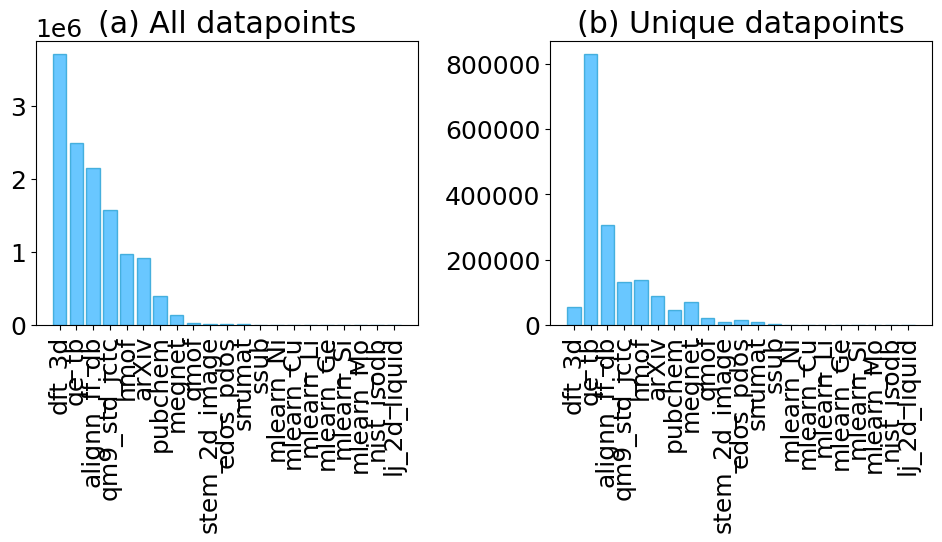

In [8]:
import numpy as np
names=[]
all_ids=[]
unique_ids=[]
for i,j in id_info.items():
    print (i,len(j),len(set(j)))
    names.append(i)
    all_ids.append(len(j))
    unique_ids.append(len(set(j)))
  

order=np.argsort(all_ids)[::-1]
names=np.array(names)[order]
all_ids=np.array(all_ids)[order]
unique_ids=np.array(unique_ids)[order]
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

the_grid = GridSpec(1, 2)
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,6))

plt.subplot(the_grid[0, 0])
plt.title('(a) All datapoints')
plt.bar(names,all_ids,facecolor = '#2ab0ff', edgecolor='#169acf',alpha=0.7)
plt.xticks(rotation=90)

plt.subplot(the_grid[0, 1])
plt.title('(b) Unique datapoints')
plt.bar(names,unique_ids,facecolor = '#2ab0ff', edgecolor='#169acf',alpha=0.7)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Mean Absolute Deviation(MAD)/Mean Absolute Error(MAE) for contributions

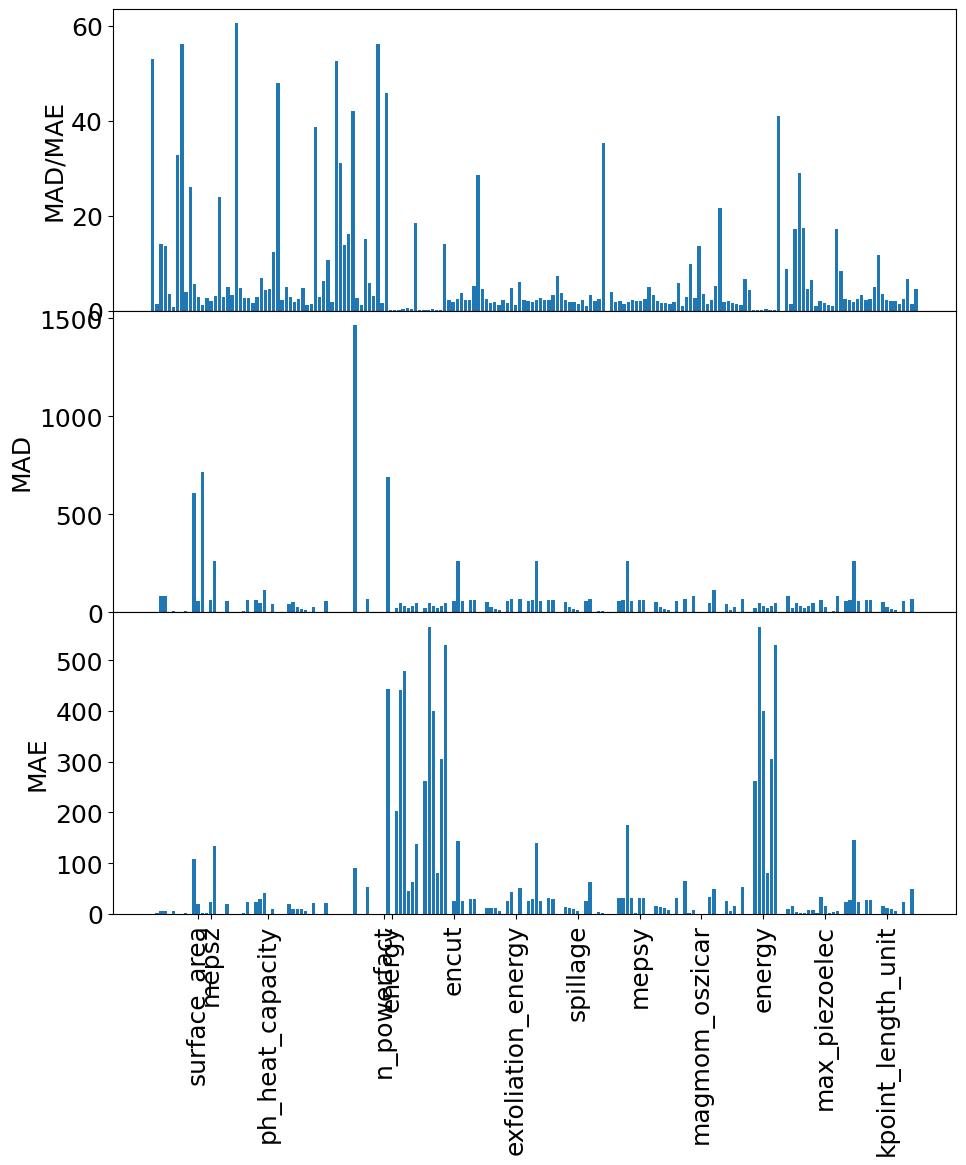

In [9]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

the_grid = GridSpec(3, 1,hspace=0.0)
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,12))

plt.subplot(the_grid[0, 0])
plt.bar(np.arange(len(mae_over_mad_vals)),mae_over_mad_vals)
plt.ylabel('MAD/MAE')
plt.xticks([])


plt.subplot(the_grid[1, 0])
plt.bar(np.arange(len(mad_vals)),mad_vals)

plt.ylabel('MAD')
plt.xticks([])

plt.subplot(the_grid[2, 0])
plt.bar(np.arange(len(mae_vals)),mae_vals)
plt.ylabel('MAE')
nm_index.pop(3)
mae_model_names.pop(3)
plt.xticks(nm_index,mae_model_names,rotation=90)

plt.tight_layout()
plt.show()
# plt.savefig('mad_mae.pdf')
# plt.close()

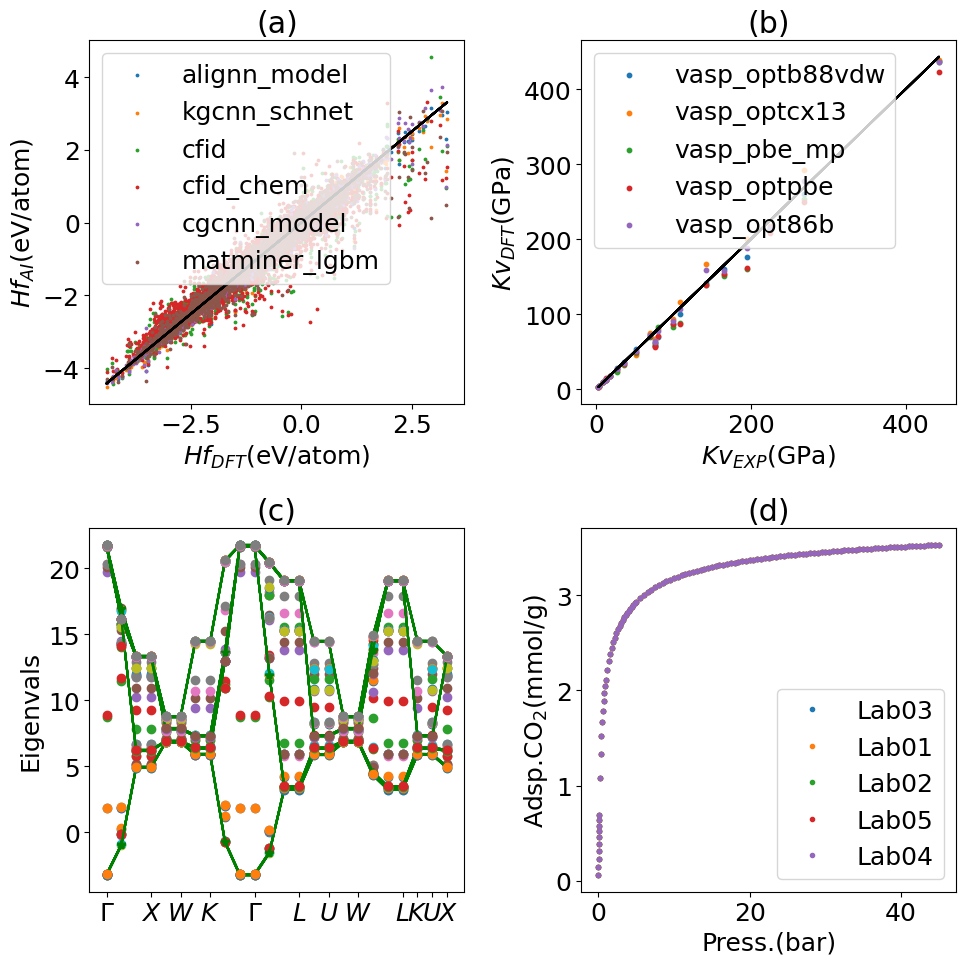

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

the_grid = GridSpec(2, 2)
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,10))

plt.subplot(the_grid[0, 0])
plt.xlabel('$Hf_{DFT}$(eV/atom)')
plt.ylabel('$Hf_{AI}$(eV/atom)')
plt.title('(a)')
for i,j in ai_form_en.items():
    plt.scatter(j['actual'],j['prediction'],s=3,label=i)
    plt.plot(j['actual'],j['actual'],c='black')
plt.legend()

plt.subplot(the_grid[0, 1])
plt.title('(b)')
plt.ylabel('$Kv_{DFT}$(GPa)')
plt.xlabel('$Kv_{EXP}$(GPa)')
for i,j in es_kv.items():
    plt.scatter(j['actual'],j['prediction'],s=10,label=i)
    plt.plot(j['actual'],j['actual'],c='black')
plt.legend()



plt.subplot(the_grid[1, 0])

for i,j in qc_eig.items():
    actual=np.array(j['actual'].values[0].split(';'),dtype='float').reshape(24,8)
    pred=np.array(j['prediction'].values[0].split(';'),dtype='float').reshape(24,8)
   
    for ii,jj in enumerate(actual.T):
#         if ii==0:
#             plt.plot(jj,'-*',c='g',label='NP')
        plt.plot(jj,'-*',c='g')
        
    for ii,jj in enumerate(pred.T):
#         if ii==0:
#             plt.plot(jj,'*',c='b',label=i.split('qiskit_vqd_SU2_')[1])
        plt.plot(jj,'o',label=i.split('qiskit_vqd_SU2_')[1])
    
kp=[0, 3, 5, 7, 10, 13, 15, 17, 20, 21, 22, 23]
lbls=['$\\Gamma$', '$X$', '$W$', '$K$', '$\\Gamma$', '$L$', '$U$', '$W$', '$L$', '$K$', '$U$', '$X$']
plt.xticks(kp,lbls)
#plt.legend()
plt.title('(c)')
plt.ylabel('Eigenvals')

plt.subplot(the_grid[1, 1])

press=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.4, 4.6, 4.8, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24, 24.5, 25, 25.5, 26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 30, 30.5, 31, 31.5, 32, 32.5, 33, 33.5, 34, 34.5, 35, 35.5, 36, 36.5, 37, 37.5, 38, 38.5, 39, 39.5, 40, 40.5, 41, 41.5, 42, 42.5, 43, 43.5, 44, 44.5, 45]

for i,j in exp_co2.items():
    actual=np.array(j['actual'].values[0].split(';'),dtype='float')
    pred=np.array(j['prediction'].values[0].split(';'),dtype='float')
    plt.plot(press,actual,'.',label=i.split('x.')[-1])
plt.legend()
plt.title('(d)')
plt.xlabel('Press.(bar)')
plt.ylabel('Adsp.CO$_2$(mmol/g)')
    
    
plt.tight_layout()
plt.show()
# plt.savefig('results_example.pdf')
# plt.close()